In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob           # Allows to list out files within a directory
import os

import librosa                  # Working with audio
import librosa.display
import IPython.display as ipd   # Allows to play audio files in notebook

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from datasets import load_dataset

from collections import defaultdict, Counter


sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = glob('mswc_microset/mswc_microset/*/clips/*/*.opus')

In [3]:
en_dev = pd.read_csv('mswc_microset/mswc_microset/en/en_dev.csv')
en_splits = pd.read_csv('mswc_microset/mswc_microset/en/en_splits.csv')
en_test = pd.read_csv('mswc_microset/mswc_microset/en/en_test.csv')
en_train = pd.read_csv('mswc_microset/mswc_microset/en/en_train.csv')

en_combined = pd.concat([en_dev, en_splits, en_test, en_train], ignore_index=True).drop_duplicates().drop(columns=['SET'])

In [4]:
es_dev = pd.read_csv('mswc_microset/mswc_microset/es/es_dev.csv')
es_splits = pd.read_csv('mswc_microset/mswc_microset/es/es_splits.csv')
es_test = pd.read_csv('mswc_microset/mswc_microset/es/es_test.csv')
es_train = pd.read_csv('mswc_microset/mswc_microset/es/es_train.csv')

es_combined = pd.concat([es_dev, es_splits, es_test, es_train], ignore_index=True).drop_duplicates().drop(columns=['SET'])

In [5]:
combined_df = pd.concat([en_combined, es_combined], ignore_index=True).drop_duplicates()

In [6]:
# Define known bilingual pairs (e.g., numbers)
bilingual_pairs = {
    "one": "uno",
    "two": "dos",
    "three": "tres",
    "four": "cuatro",
    "five": "cinco",
    "six": "seis",
    "seven": "siete",
    "eight": "ocho",
    "nine": "nueve",
    "zero": "cero"
}

# Get all words from either language
english_words = bilingual_pairs.keys()
spanish_words = bilingual_pairs.values()

# Filter the DataFrame
bilingual_subset = combined_df[
    combined_df['WORD'].isin(english_words) |
    combined_df['WORD'].isin(spanish_words)
]

In [7]:
file_limit = 300

valid_words = list(bilingual_pairs.keys()) + list(bilingual_pairs.values())
color_mapping = {word: i for i, word in enumerate(bilingual_pairs.keys())}

In [8]:
word_counts = defaultdict(int)
filtered_files, filtered_labels = [], []

for file in ds:
    word = os.path.basename(os.path.dirname(file))
    if word in valid_words and word_counts[word] < file_limit:
        filtered_files.append(file)
        filtered_labels.append(word)
        word_counts[word] += 1

print("Files per word:", Counter(filtered_labels))

Files per word: Counter({'eight': 300, 'five': 300, 'four': 300, 'nine': 300, 'one': 300, 'seven': 300, 'six': 300, 'three': 300, 'two': 300, 'zero': 300, 'cinco': 300, 'cuatro': 300, 'dos': 300, 'nueve': 300, 'ocho': 300, 'seis': 300, 'siete': 300, 'tres': 300, 'uno': 300, 'cero': 88})


In [9]:
filtered_by_silent = []
i = 0
for file in filtered_files:
    y, sr = librosa.load(file)
    rms = librosa.feature.rms(y=y)[0]
    mean_rms = np.mean(rms)
    if mean_rms > 0.0001:
        filtered_by_silent.append(file)
    else:
         print(f"File {i} removed")
    i += 1

In [10]:
embeddings = []

for file in filtered_files:
    y, sr = librosa.load(file)
    y, _ = librosa.effects.trim(y, top_db=40)
    s = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # Reduced from 256 to 20 for better PCA
    sb_db_mel = librosa.amplitude_to_db(s, ref=np.max)
    embeddings.append(np.mean(sb_db_mel, axis=1))

TypeError: mel() got an unexpected keyword argument 'n_mfcc'

In [11]:
scaler = StandardScaler()
pca = PCA(n_components=2)
projection = pca.fit_transform(scaler.fit_transform(np.array(embeddings)))

In [12]:
# Prepare DataFrame with proper color grouping
df = pd.DataFrame({
    "x": projection[:, 0],
    "y": projection[:, 1],
    "word": filtered_labels,
    "language": ["English" if word in bilingual_pairs else "Spanish" for word in filtered_labels],
    "color_group": [word if word in bilingual_pairs else
                   list(bilingual_pairs.keys())[list(bilingual_pairs.values()).index(word)]
                   for word in filtered_labels]
})

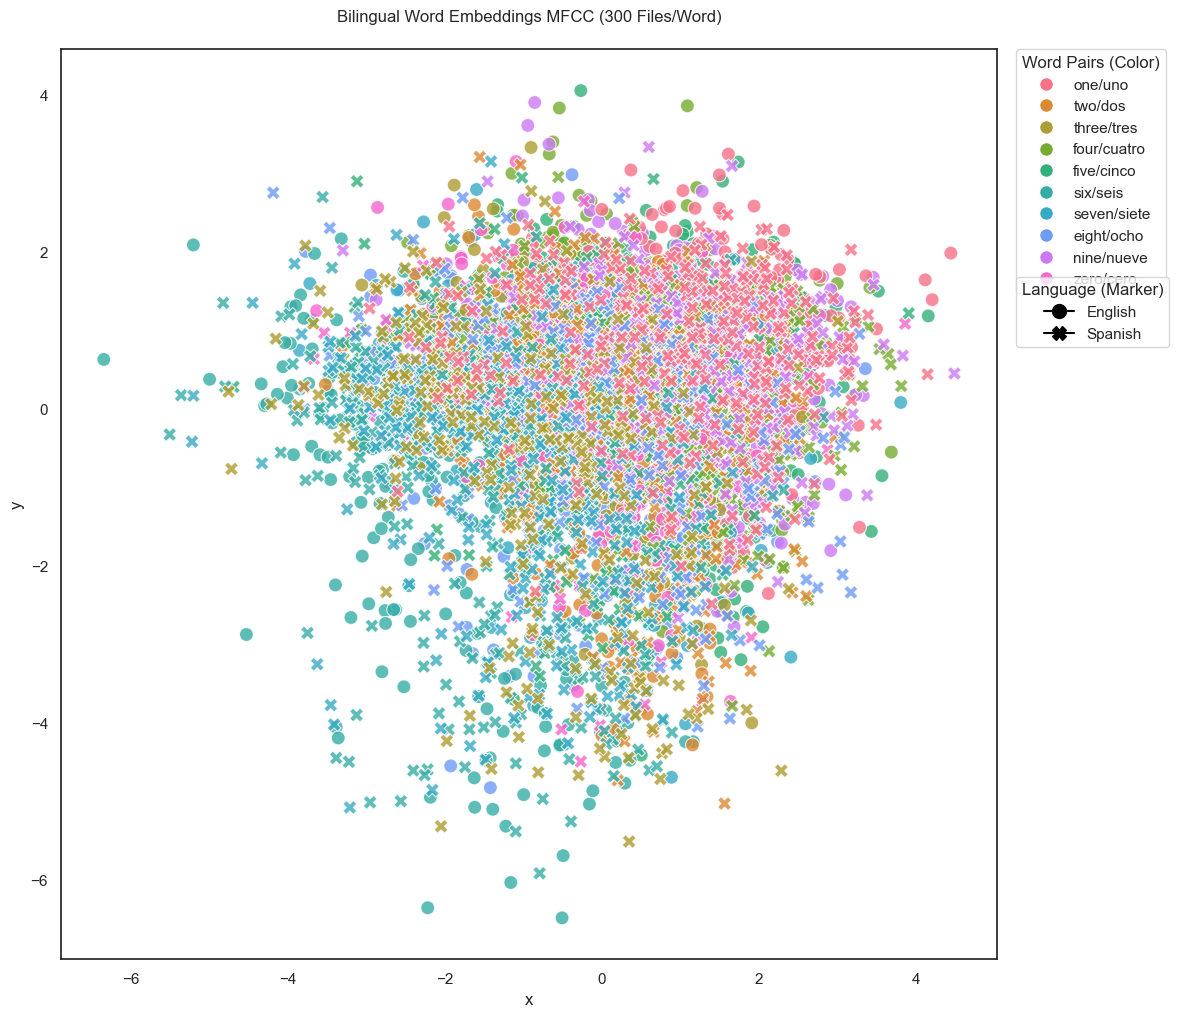

In [13]:
# Create numeric color codes based on the English words
color_codes = {word: i for i, word in enumerate(bilingual_pairs.keys())}
df['color_code'] = df['color_group'].map(color_codes)

plt.figure(figsize=(15, 15))
scatter = sns.scatterplot(
    x="x", y="y",
    hue="color_code",
    style="language",
    data=df,
    palette=sns.color_palette("husl", n_colors=len(bilingual_pairs)),
    s=100,
    alpha=0.8,
    legend=False
)

# Create custom legend elements
colors = sns.color_palette("husl", n_colors=len(bilingual_pairs))

# Word pairs legend (color only)
word_legend_elements = [
    plt.Line2D([0], [0],
              marker='o',
              color='w',
              markerfacecolor=colors[i],
              markersize=10,
              label=f"{eng}/{spa}")
    for i, (eng, spa) in enumerate(bilingual_pairs.items())
]

# Language markers legend (shape only)
language_legend_elements = [
    plt.Line2D([0], [0],
              marker='o',
              color='black',
              markerfacecolor='black',
              markersize=10,
              label='English'),
    plt.Line2D([0], [0],
              marker='X',
              color='black',
              markerfacecolor='black',
              markersize=10,
              label='Spanish')
]

# Create two separate legends with proper spacing
word_legend = plt.legend(handles=word_legend_elements,
                        bbox_to_anchor=(1.02, 1),
                        loc='upper left',
                        title='Word Pairs (Color)',
                        borderaxespad=0.)

plt.gca().add_artist(word_legend)  # Add first legend manually

plt.legend(handles=language_legend_elements,
           bbox_to_anchor=(1.02, 0.75),  # Positioned below first legend
           loc='upper left',
           title='Language (Marker)',
           borderaxespad=0.)

plt.title(f"Bilingual Word Embeddings MFCC ({file_limit} Files/Word)", pad=20)
plt.gca().set_aspect('equal')
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin
plt.show()

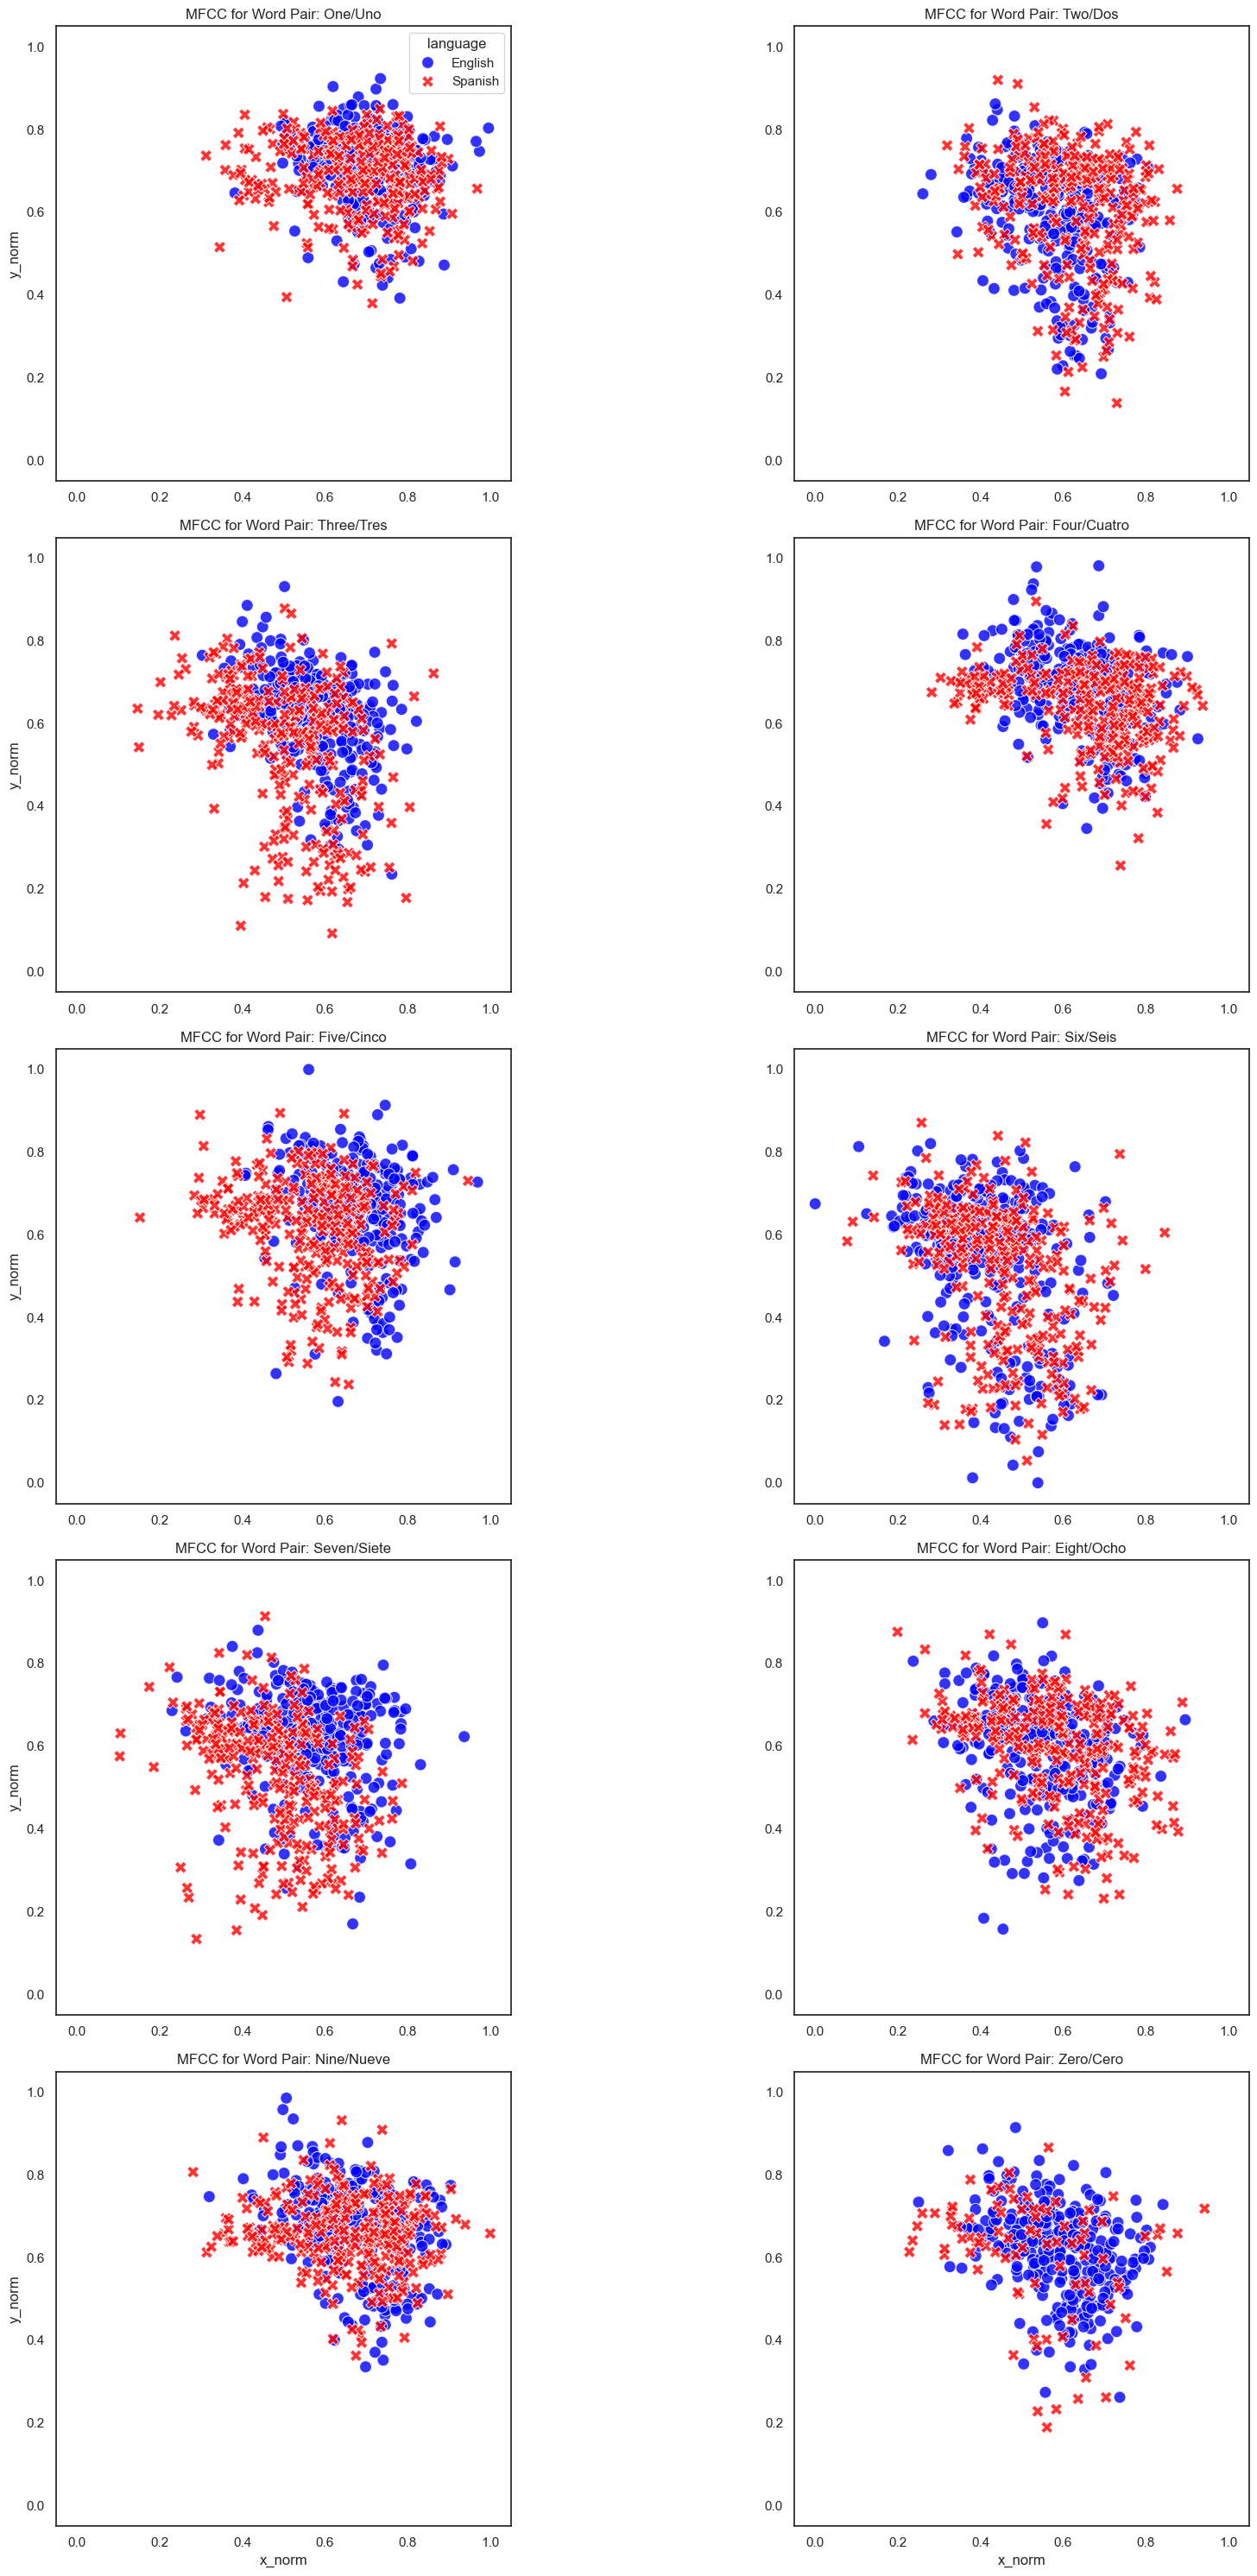

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the PCA projections to [0,1] range
coord_scaler = MinMaxScaler()
df[['x_norm', 'y_norm']] = coord_scaler.fit_transform(df[['x', 'y']])

# Create figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
axes = axes.flatten()

# Set consistent axis limits for all plots
x_min, x_max = df['x_norm'].min(), df['x_norm'].max()
y_min, y_max = df['y_norm'].min(), df['y_norm'].max()

for i, (eng, spa) in enumerate(bilingual_pairs.items()):
    ax = axes[i]
    pair_df = df[df['color_group'] == eng]

    # Plot with normalized coordinates
    sns.scatterplot(
        x="x_norm", y="y_norm",
        hue="language",
        style="language",
        data=pair_df,
        palette={"English": "blue", "Spanish": "red"},
        s=100,
        alpha=0.8,
        ax=ax,
        legend=True if i == 0 else False
    )

    # Set consistent axis limits
    ax.set_xlim(x_min - 0.05, x_max + 0.05)  # 5% padding
    ax.set_ylim(y_min - 0.05, y_max + 0.05)

    ax.set_title(f"MFCC for Word Pair: {eng.capitalize()}/{spa.capitalize()}")
    ax.set_aspect('equal')

    # Remove redundant labels
    if i % 2 != 0:
        ax.set_ylabel('')
    if i < 8:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()